### SENTIMENT ANALYSIS ON IGBO DATA

### Objective

- Build a model that can classify sentiments on news articles as positive, neutral or negative.

### Data

The data was gotten from the NaijaSenti's manually annotated Igbo tweets found <a href = "https://github.com/hausanlp/NaijaSenti/tree/main"> here </a>.

In [1]:
# uncomment the code below to install
!pip install wordcloud emoji transformers evaluate
!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
t

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import emoji
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud #ensure wordcloud is installed
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import nltk

%matplotlib inline

In [3]:
# load data
data1 = pd.read_csv("train.tsv", delimiter='\t')
data2 = pd.read_csv("dev.tsv", delimiter='\t')

data = pd.concat([data1, data2])
data.sample(5)

,tweet,label
2921,#NP ima echi @user #oge ndi igbo # @user @user...,neutral
4430,"I taa anyi alu n'isi isoro ntutu, anyi ga-ata ...",neutral
3412,@user @user @user @user @user @user @user Onye...,neutral
7894,"🎼isi ike ndu, ke n'adighi atata ,aka aka ya, a...",positive
6061,"@user Onye Nkwerre ga-ashị: """"""""...onye nwere ...",neutral


### Data Wrangling and Preprocessing

In [4]:
data.shape

(12033, 2)

In [5]:
# check distribution of sentiments
data["label"].value_counts()

,count
label,
neutral,5319
positive,3644
negative,3070


In [6]:
# checking for missing values
data.isnull().sum()

,0
tweet,0
label,0


In [7]:
def clean(data,column):

  # save the pattern for the punctuation and special characters in regex
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))

  # Replace emojis with text
  #data['clean_tweet'] = data['clean_tweet'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))

  # replace the punctuation with nothing for each word in the list
  # and join the words back into a string
  data[column] = data[column].apply(lambda x: ' '.join([re_punc.sub('', word) for word in x.split()]))

  # remove extra special characters not handled above
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r'[’,-, @]','', word) for word in x.split()]))

  # remove links
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r'http\S+|www.\S+', '', word) for word in x.split()]))

  # remove html tags
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r"<.*?>", '', word) for word in x.split()]))

  # remove extra whitspace
  data[column] = data[column].apply(lambda x: x.strip())

  # lower case
  data[column] = data[column].apply(lambda x: x.lower())

  print("Data successfully cleaned!")


  return data[column]

In [8]:
data['clean_tweet'] = clean(data, 'tweet')
data['clean_tweet'].sample(10)

Data successfully cleaned!


,clean_tweet
5715,user user ndị ahụ na agba ha chi clock nigeria...
2990,np akwa ibom user oge ndi igbo user
5764,user nwa onye onitsha
3948,user user user user user user anyi kwu gi na a...
11,user nna ehh ụfọdụ ụmụ nwoke dara iberibe 🤦🏽‍♂️
9083,chineke bụ eze nwanne agba ọ m kilometer iri n...
9117,user comman see ebe ndi malaysia naeme ego ka ...
8561,user user chai chineke nna igbo ndi oma ekele ...
2894,user before ị na e miss bịa bogodum mmiri a kà...
1579,sars bu ndi oshi ndi ogbu ara obara onye obula...


In [9]:
from collections import defaultdict

# Initialize a defaultdict with integer values to store word frequencies
vocab = defaultdict(int)

corpus = data["clean_tweet"]

# Loop through each sentence in the corpus and count no. of occurrence of each word
for article in corpus.apply(lambda x: x.split()):
    for word in article:
        vocab[word] += 1

# Convert the defaultdict vocab to a regular dictionary for easier handling and sorting
# and sort the dictionary by word frequency in descending order
sorted_vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))

# Display the sorted vocabulary with each word and its frequency count
#print("Vocabulary with Frequencies:", sorted_vocab)

In [10]:
#  remove stopwords
IGBO_STOPWORDS = {
    "ihe",
    "na",
    "nke",
    "mana",
    "n’",
    "ka",
    "ma",
    "ya",
    "si",
    "ga",
    "di",
    "onye",
    "ndị",
    "bụ",
    "ọ",
    "a",
    "e",
    "i",
    "ị",
    "o",
    "ha",
    "unu",
    "anyị",
    "anyi",
    "gi"
    "gị",
    "m",
    "mụ",
    "bụ",
    "bu",
    "ọ bụla",
    "ọbụna",
    "gịnị",
    "ebee",
    "olee",
    "ole",
    "ahụ",
    "kedụ",
    "maka",
    "mụ onwe m",
    "onwe m",
    "gị onwe gị",
    "onwe gị",
    "ya onwe ya",
    "onwe ya",
    "anyị onwe anyị",
    "onwe anyị",
    "unu onwe unu",
    "onwe unu",
    "ha onwe ha",
    "onwe ha",
    "mụ wa",
    "gị wa",
    "ya wa",
    "anyị wa",
    "unu wa",
    "ha wa",
    "mụ nwa",
    "gị nwa",
    "ya nwa",
    "anyị nwa",
    "unu nwa",
    "ha nwa",
    "na",
    "n’",
    "n'",
    "n\"",
    "n’ime",
    "nime",
    "niime",
    "n’elu",
    "nelu",
    "neelu",
    "n’ihi",
    "niihi",
    "nihi",
    "naka",
    "naaka",
    "n’aka",
    "nakụkụ",
    "naakụkụ",
    "n’akụkụ",
    "n’okpuru",
    "nokpuru",
    "noookpuru",
    "n’ebe",
    "nebe",
    "nebee",
    "n’ebee",
    "n’anya",
    "nanya",
    "n’ụzọ",
    "nụzọ",
    "na nkọnkọ",
    "n’azụ",
    "nazụ",
    "ganye ma",
    "ganye na",
    "ya mere",
    "gbasara",
    "site",
    "mgbe",
    "n’ezie",
    "nezie",
    "kama",
    "ka ọ bụ",
    "kaọbụ",
    "ka ọ bụrụ",
    "kaọbụrụ",
    "ma ọ bụ",
    "maọbụ",
    "ma ọ bụrụ",
    "maọbụrụ",
    "kamgbe",
    "kemgbe",
    "nwere ike",
    "mee",
    "gunyere",
    "banyere"
    "niile",
    "nile",
    "ọtụtụ",
    "ụfọdụ",
    "ka o si na dị",
    "ka o si dị",
    "ka ọ na dị",
    "maka - because",
    "kwa",
    "mana",
    "maọbụ",
    "tupu",
    "tutuu",
    "dị",
    "dịka",
    "dịghị",
    "ghị",
    "beghi",
    "bụghị",
    "gaghị",
    "ee",
    "mba",
    "ihe",
    "ruo",
    "rute",
    "igbo"}

print(len(IGBO_STOPWORDS))

137


In [11]:
for word, freq in sorted_vocab.items():
  if freq >= 1000 and word not in IGBO_STOPWORDS:
    IGBO_STOPWORDS.add(word)
IGBO_STOPWORDS = IGBO_STOPWORDS.union(ENGLISH_STOP_WORDS)
print(len(IGBO_STOPWORDS))

456


In [12]:
def remove_stopwords(text, stopwords):
    words = text.split()  # tokenize by whitespace
    filtered_words = [word for word in words if word not in stopwords]
    return " ".join(filtered_words)

# Apply the function to each article in the DataFrame
data["clean_tweet"] = data["clean_tweet"].apply(lambda row: remove_stopwords(row, IGBO_STOPWORDS))

data["clean_tweet"].sample(10)

,clean_tweet
356,nne rapu ara uchundi ogbeyinndi nzuzu😂 set awo...
1488,ekwensu micha onu
235,ara isi ozugo
5363,otoga ochi 😂 uru
5809,😂😂😂😂😂 “m eji ike ezem tachasia aji nike”😂😂😂😂😂😂...
1046,⏰middaylounge 🎙️ w x x 🎼 nowplaying ▶️ obodo i...
103,chukwu biko napu ekwensu ike
5352,tụọ iche 😌😌
1965,mum voice ekwensu ekwela ojoe ghaghi banye egb...
3101,iji egwu egwu 😂


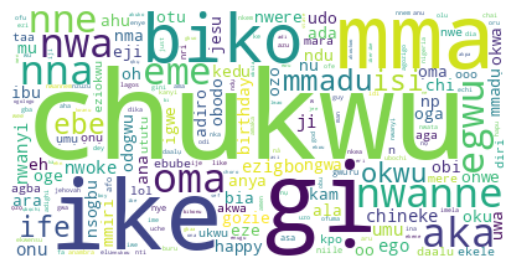

In [13]:
# create word cloud for the review body
text = " ".join([t for t in data['clean_tweet']])
word_cloud = WordCloud(stopwords = IGBO_STOPWORDS, collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observation

There are emojis in the tweets. Emojis can be beneficial in determining the sentiment of a text. To test this hypothesis, the performance of different models will be tested to show how emojis can affect them.

<b> 1. Clean data with emoji as is ==> data['clean_tweet'] </b>

<b> 2. Clean data with emoji removed ==> data['tweet_without_emoji'] </b>

<b> 3. Clean data with emoji replaced with the description in English ==> data['tweet_with_emoji_replaced'] </b>

<b> 4. Clean data with emoji placed at the end of the text and replaced with the description in English ==> data['tweet_with_emoji_replaced_at_end'] </b>

In [15]:
data['clean_tweet'].head()

,clean_tweet
0,nna ike gwuru ooo 😂
1,chineke nna kezi
2,lol isi adirokwanu nma 😐😒😒😒
3,haha fulani herdsmen akpa amu retweet rie nsi 😝
4,nna ghetto aru biko


In [18]:
# remove emojis
data['tweet_without_emoji'] = data['clean_tweet'].apply(lambda x: emoji.replace_emoji(x, replace=''))
data['tweet_without_emoji'].head()

,tweet_without_emoji
0,nna ike gwuru ooo
1,chineke nna kezi
2,lol isi adirokwanu nma
3,haha fulani herdsmen akpa amu retweet rie nsi
4,nna ghetto aru biko


In [19]:
# Replace emojis with text
data['tweet_with_emoji_replaced'] = data['clean_tweet'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))
data['tweet_with_emoji_replaced'].head()

,tweet_with_emoji_replaced
0,nna ike gwuru ooo face_with_tears_of_joy
1,chineke nna kezi
2,lol isi adirokwanu nma neutral_face unamused...
3,haha fulani herdsmen akpa amu retweet rie nsi ...
4,nna ghetto aru biko


In [20]:
# Function to extract emojis from text
def extract_emojis(text):
    return ' '.join(emoji.distinct_emoji_list(text))

# Apply function to DataFrame and create new column
data['tweet_with_emoji_replaced_at_end'] = data['tweet_without_emoji'] + data['clean_tweet'].apply(extract_emojis).apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))
data['tweet_with_emoji_replaced_at_end'].head()

,tweet_with_emoji_replaced_at_end
0,nna ike gwuru ooo face_with_tears_of_joy
1,chineke nna kezi
2,lol isi adirokwanu nma unamused_face neutra...
3,haha fulani herdsmen akpa amu retweet rie nsi ...
4,nna ghetto aru biko


In [14]:
# fraction of reviews
data.label.value_counts()/len(data)

,count
label,
neutral,0.442034
positive,0.302834
negative,0.255132


### Vectorization

Columns must be converted to a numerical format that the ML model can understand.

In [15]:
# Encode labels
#label_encoder = LabelEncoder()
#data['label'] = label_encoder.fit_transform(data['label'])
data['label'] = np.asarray(data['label'])
label_map = {"negative": 0, "neutral": 1, "positive": 2}
data['label'] = data['label'].map(label_map)
data['label'] = np.asarray(data['label'])

# Verify the mapping
data['label'].sample(5)

,label
9041,2
3531,1
761,1
6780,1
7919,2


<b> Label Encoding </b>

0 - negative

1 - neutral

2 - positive

In [21]:
def vectorize(data,column):
    # define the vectorizer and specify the arguments, ngrams (1,3) considers unigram - one word, bigram - two consecutive words, trigram - three words
    text = [t for t in data[column]]
    vect = TfidfVectorizer(ngram_range=(1, 3), max_features=500, token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(text)
    # Transform the vectorizer
    num_txt = vect.transform(text).toarray()

    return num_txt

embeddings1 = vectorize(data,'clean_tweet')
embeddings2 = vectorize(data,'tweet_without_emoji')
embeddings3 = vectorize(data,'tweet_with_emoji_replaced')
embeddings4 = vectorize(data,'tweet_with_emoji_replaced_at_end')

In [22]:
# Build model and calculate the accuracy
def build(model):
    model = model().fit(X_train, y_train)

    return model
def result(model):
    # predicting and calculating accuracy
    predict = model.predict(X_test)
    # classification report
    print(classification_report(y_test,predict))
    # plot confusion matrix
    cm = confusion_matrix(y_test,predict)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

### Case 1: Texts with emojis as is

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       634
           1       0.71      0.83      0.77      1063
           2       0.83      0.77      0.80       710

    accuracy                           0.75      2407
   macro avg       0.76      0.73      0.74      2407
weighted avg       0.75      0.75      0.75      2407



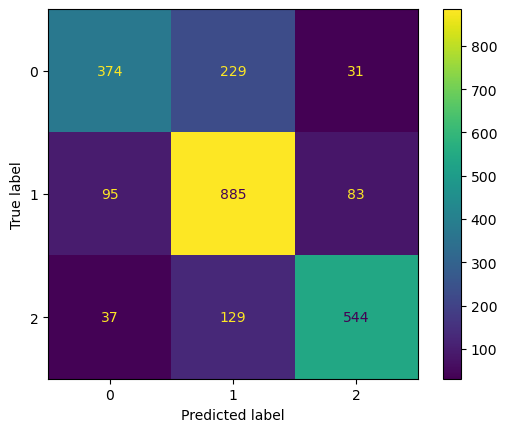

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       634
           1       0.71      0.76      0.74      1063
           2       0.77      0.80      0.79       710

    accuracy                           0.72      2407
   macro avg       0.72      0.71      0.71      2407
weighted avg       0.72      0.72      0.72      2407



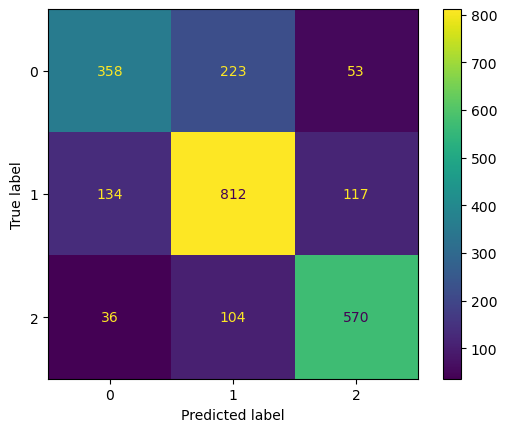

<class 'sklearn.naive_bayes.GaussianNB'>
              precision    recall  f1-score   support

           0       0.40      0.90      0.55       634
           1       0.71      0.33      0.45      1063
           2       0.87      0.59      0.70       710

    accuracy                           0.56      2407
   macro avg       0.66      0.61      0.57      2407
weighted avg       0.68      0.56      0.55      2407



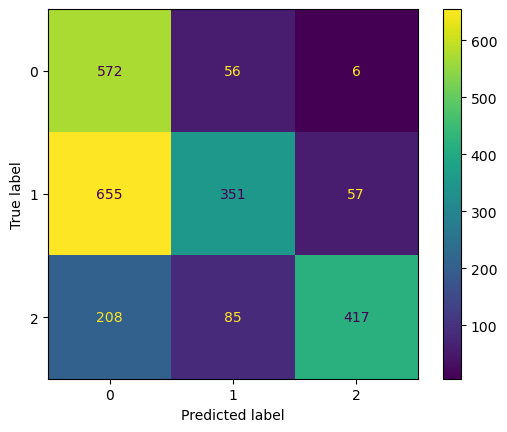

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.58      0.59      0.59       634
           1       0.70      0.69      0.69      1063
           2       0.74      0.76      0.75       710

    accuracy                           0.68      2407
   macro avg       0.67      0.68      0.68      2407
weighted avg       0.68      0.68      0.68      2407



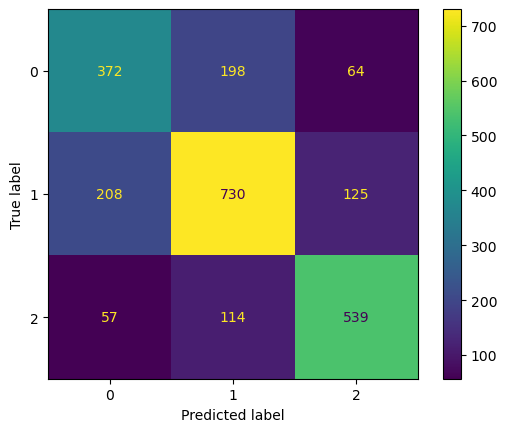

In [ ]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings1, y, test_size = 0.2, random_state = 4)
# include naive bayes and svm
models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

### Obserrvations
1. The LogReg model had the highest accuracy.
2. All models had the lowest precision values for the negative sentiment, which is also the minority class in the dataset, representing 25.5% of the entire dataset. This indicates that compared to other sentiments, the negative sentiment prediction was the least accurate. This can also be seen in the confusionmatrix.
3. Only the GaussianNB model had higher recall value for the negative sentiment. This shows that it was best at identifying the minority class than the other models.

### Case 2: Texts with emojis removed

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       634
           1       0.71      0.83      0.77      1063
           2       0.83      0.77      0.80       710

    accuracy                           0.75      2407
   macro avg       0.76      0.73      0.74      2407
weighted avg       0.75      0.75      0.75      2407



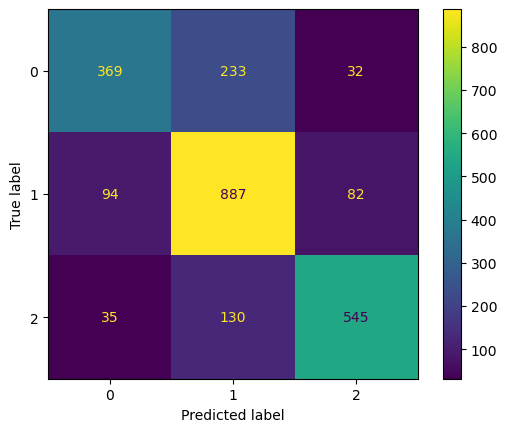

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       634
           1       0.72      0.77      0.74      1063
           2       0.76      0.79      0.78       710

    accuracy                           0.72      2407
   macro avg       0.72      0.71      0.71      2407
weighted avg       0.72      0.72      0.72      2407



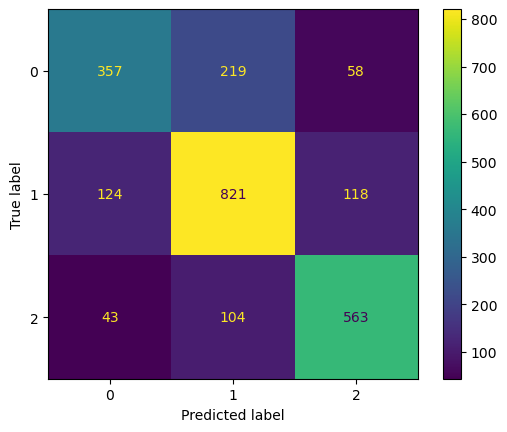

<class 'sklearn.naive_bayes.GaussianNB'>
              precision    recall  f1-score   support

           0       0.40      0.90      0.55       634
           1       0.72      0.33      0.46      1063
           2       0.87      0.58      0.70       710

    accuracy                           0.56      2407
   macro avg       0.66      0.61      0.57      2407
weighted avg       0.68      0.56      0.55      2407



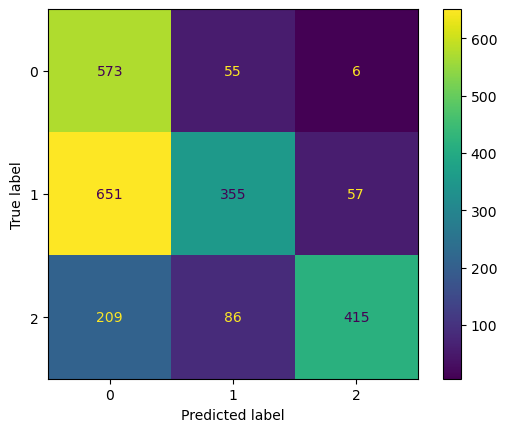

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.58      0.57      0.58       634
           1       0.69      0.69      0.69      1063
           2       0.74      0.75      0.75       710

    accuracy                           0.68      2407
   macro avg       0.67      0.67      0.67      2407
weighted avg       0.68      0.68      0.68      2407



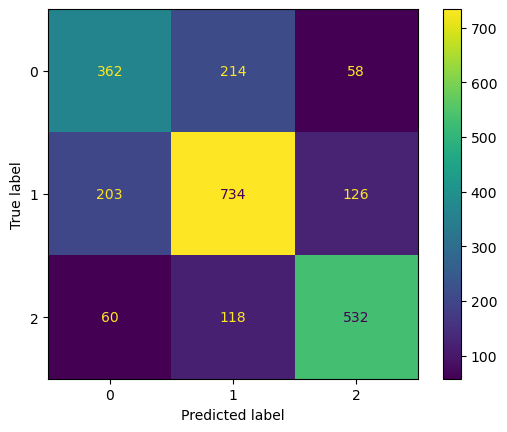

In [ ]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings2, y, test_size = 0.2, random_state = 4)

models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

### Observations
1. Removing the emojis didn't significantly affect any of the evaluation metrics for all four models.

### Case 3: Texts with emojis replaced with text description

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       634
           1       0.72      0.82      0.76      1063
           2       0.83      0.77      0.80       710

    accuracy                           0.75      2407
   macro avg       0.75      0.73      0.74      2407
weighted avg       0.75      0.75      0.74      2407



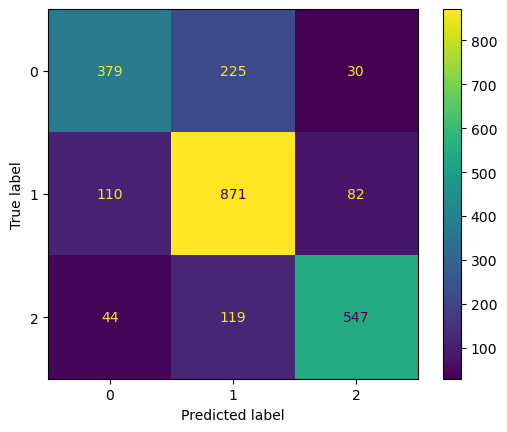

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.67      0.57      0.62       634
           1       0.71      0.75      0.73      1063
           2       0.76      0.80      0.78       710

    accuracy                           0.72      2407
   macro avg       0.72      0.71      0.71      2407
weighted avg       0.72      0.72      0.72      2407



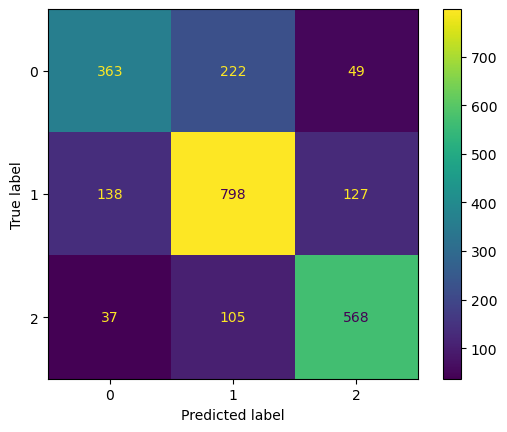

<class 'sklearn.naive_bayes.GaussianNB'>
              precision    recall  f1-score   support

           0       0.41      0.89      0.56       634
           1       0.71      0.34      0.46      1063
           2       0.83      0.61      0.71       710

    accuracy                           0.57      2407
   macro avg       0.65      0.61      0.58      2407
weighted avg       0.67      0.57      0.56      2407



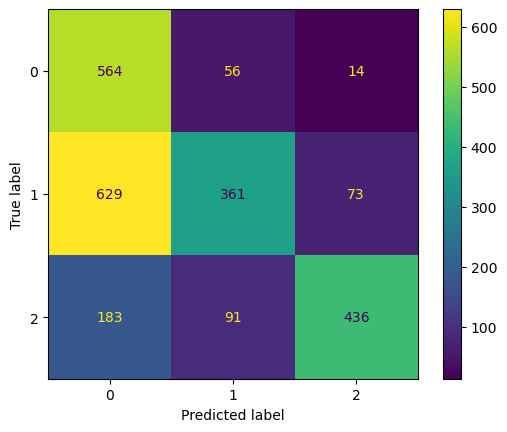

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       634
           1       0.67      0.68      0.68      1063
           2       0.72      0.76      0.74       710

    accuracy                           0.67      2407
   macro avg       0.66      0.66      0.66      2407
weighted avg       0.67      0.67      0.67      2407



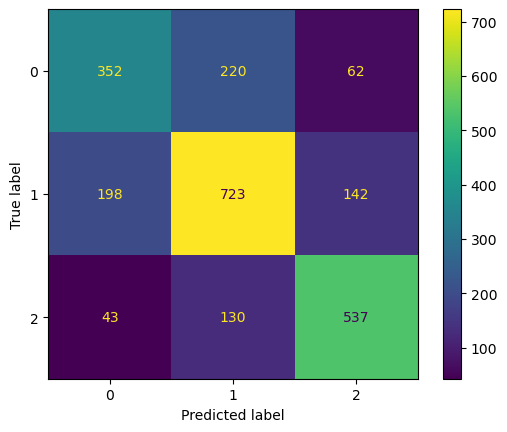

In [ ]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings3, y, test_size = 0.2, random_state = 4)

models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

### Observation
1. This change slightly reduced the performance of the models.

### Case 4: Texts with emoji placed at the end and replaced with the description

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.73      0.59      0.65       634
           1       0.72      0.83      0.77      1063
           2       0.83      0.78      0.80       710

    accuracy                           0.75      2407
   macro avg       0.76      0.73      0.74      2407
weighted avg       0.75      0.75      0.75      2407



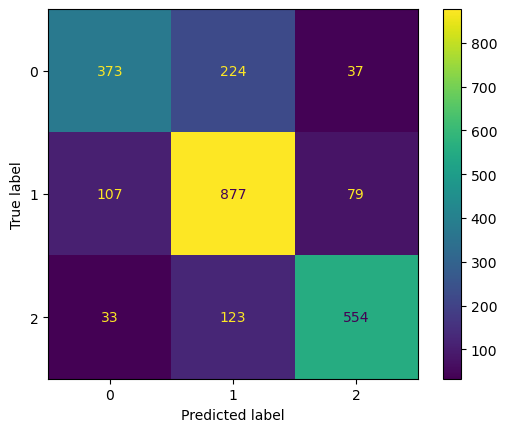

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       634
           1       0.71      0.77      0.74      1063
           2       0.77      0.80      0.79       710

    accuracy                           0.72      2407
   macro avg       0.72      0.71      0.71      2407
weighted avg       0.72      0.72      0.72      2407



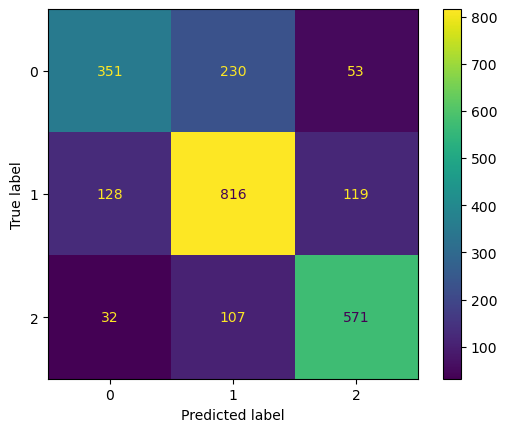

<class 'sklearn.naive_bayes.GaussianNB'>
              precision    recall  f1-score   support

           0       0.42      0.90      0.57       634
           1       0.72      0.37      0.49      1063
           2       0.86      0.59      0.70       710

    accuracy                           0.57      2407
   macro avg       0.67      0.62      0.59      2407
weighted avg       0.68      0.57      0.57      2407



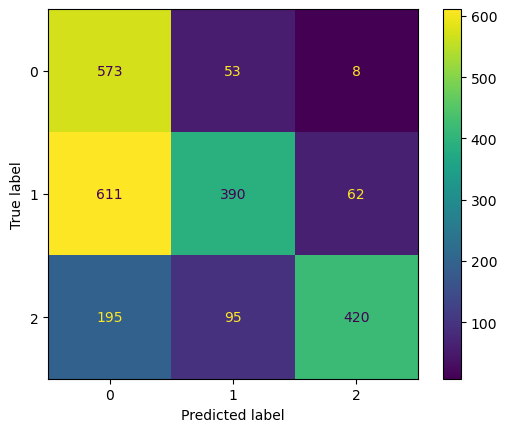

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.57      0.58      0.58       634
           1       0.67      0.67      0.67      1063
           2       0.73      0.73      0.73       710

    accuracy                           0.66      2407
   macro avg       0.66      0.66      0.66      2407
weighted avg       0.66      0.66      0.66      2407



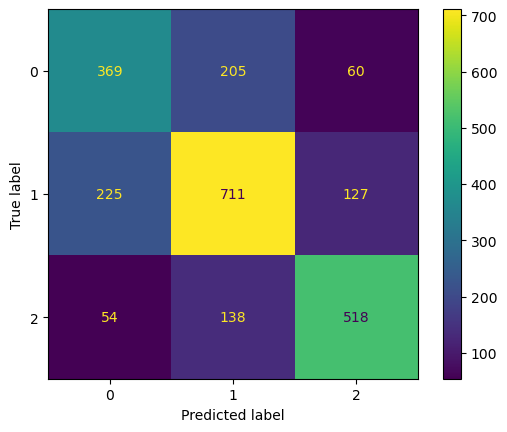

In [ ]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings4, y, test_size = 0.2, random_state = 4)

models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

Overall, the changes in emoji didn't produce a reasonable improvement in the performance of the models.

### Deep Learning

In [23]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dropout,
    Flatten,
    Dense,
    LSTM,
    Embedding
)
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [24]:
from tensorflow.keras.utils import to_categorical
num_classes = 3
y = to_categorical(data['label'], num_classes=num_classes)
#data["clean_tweet"]
#data["tweet_without_emoji"]
#data["tweet_with_emoji_replaced"]
#data["tweet_with_emoji_replaced_at_end"]
print(y.shape)

(12033, 3)


### Case 1

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings1, y, test_size=0.2, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)

In [26]:
# Initiating model
def build():
    model = Sequential()
    #model.add(LSTM(64, input_shape=(max_len1, embedding_dim), return_sequences=True))
    #model.add(LSTM(128, return_sequences=True))
    model.add(Input(shape = (X_train.shape[1],)))
    model.add(Dense(64))
    model.add(Activation('relu'))# Activation function

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(3, activation = 'softmax')) # multiClassification layer
    return model

In [27]:
model1 = build()

In [28]:
# Create Adam optimizer with custom learning rate
adam_optimizer = Adam(learning_rate=0.001)

# Compiling model
model1.compile(optimizer = adam_optimizer,
              loss = 'categorical_crossentropy', # change to sparse_categorical_crossentropy for multiclass where each sample can only belong to one class
              metrics = ['accuracy']) # Evaluation metric

In [ ]:
learning_rate_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.7, patience=3, verbose=1, min_delta=1e-4, mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 503,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model1.keras',
                            monitor = 'val_loss',
                            save_best_only = True)

In [ ]:
model1.fit(X_train, y_train, epochs=50, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, learning_rate_reduce, early_stopping])

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4740 - loss: 1.0285 - val_accuracy: 0.7132 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7430 - loss: 0.6471 - val_accuracy: 0.7290 - val_loss: 0.6492 - learning_rate: 0.0010
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7685 - loss: 0.5758 - val_accuracy: 0.7190 - val_loss: 0.6622 - learning_rate: 0.0010
Epoch 4/50
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7827 - loss: 0.5459
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7823 - loss: 0.5462 - val_accuracy: 0.7215 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8015 - loss: 0.5078 - val_accuracy: 0.7257 - val_loss: 0.6670 - learning_rate: 7.0000e-04
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8042 - loss: 0.4913

In [ ]:
# Load the best model
best_model1 = tf.keras.models.load_model('best_model1.keras')

In [ ]:
best_model1.evaluate(X_test, y_test, batch_size=64, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7649 - loss: 0.5822  


[0.6057668328285217, 0.7583056688308716]

### Case 2

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings2, y, test_size=0.3, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)
model2 = build()
# Create Adam optimizer with custom learning rate
adam_optimizer = Adam(learning_rate=0.001)

# Compiling model
model2.compile(optimizer = adam_optimizer,
              loss = 'categorical_crossentropy', # change to sparse_categorical_crossentropy for multiclass where each sample can only belong to one class
              metrics = ['accuracy']) # Evaluation metric

In [ ]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 30,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model2.keras',
                            monitor = 'val_loss',
                            save_best_only = True)

In [ ]:
model2.fit(X_train, y_train, epochs=50, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4570 - loss: 1.0429 - val_accuracy: 0.7091 - val_loss: 0.7142
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7355 - loss: 0.6498 - val_accuracy: 0.7313 - val_loss: 0.6550
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7659 - loss: 0.5786 - val_accuracy: 0.7302 - val_loss: 0.6677
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7880 - loss: 0.5234 - val_accuracy: 0.7346 - val_loss: 0.6604
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8047 - loss: 0.4993 - val_accuracy: 0.7313 - val_loss: 0.6611
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8143 - loss: 0.4693 - val_accuracy: 0.7330 - val_loss: 0.6849
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss: 0.4499 - val_accuracy: 0.7357 - val_loss: 0.6941
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8455 - loss: 0.4078 - val_accuracy: 0.

In [ ]:
# Load the best model
best_model2 = tf.keras.models.load_model('best_model2.keras')
best_model2.evaluate(X_test, y_test, batch_size=64, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7603 - loss: 0.6185


[0.6266900300979614, 0.7490304708480835]

### Case 3

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings2, y, test_size=0.3, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)
model3 = build()
# Create Adam optimizer with custom learning rate
adam_optimizer = Adam(learning_rate=0.001)

# Compiling model
model3.compile(optimizer = adam_optimizer,
              loss = 'categorical_crossentropy', # change to sparse_categorical_crossentropy for multiclass where each sample can only belong to one class
              metrics = ['accuracy']) # Evaluation metric
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 30,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model3.keras',
                            monitor = 'val_loss',
                            save_best_only = True)
model3.fit(X_train, y_train, epochs=50, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4697 - loss: 1.0382 - val_accuracy: 0.7152 - val_loss: 0.7111
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7413 - loss: 0.6362 - val_accuracy: 0.7252 - val_loss: 0.6543
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7697 - loss: 0.5713 - val_accuracy: 0.7130 - val_loss: 0.6665
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7880 - loss: 0.5302 - val_accuracy: 0.7319 - val_loss: 0.6590
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8006 - loss: 0.5078 - val_accuracy: 0.7307 - val_loss: 0.6639
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8163 - loss: 0.4802 - val_accuracy: 0.7108 - val_loss: 0.6834
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8235 - loss: 0.4558 - val_accuracy: 0.7285 - val_loss: 0.6915
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8270 - loss: 0.4376 - val_accuracy: 0.

In [ ]:
# Load the best model
best_model3 = tf.keras.models.load_model('best_model3.keras')
best_model3.evaluate(X_test, y_test, batch_size=64, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7455 - loss: 0.6281


[0.6354470252990723, 0.73850417137146]

### Case 4

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings2, y, test_size=0.3, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)
model4 = build()
# Create Adam optimizer with custom learning rate
adam_optimizer = Adam(learning_rate=0.001)

# Compiling model
model4.compile(optimizer = adam_optimizer,
              loss = 'categorical_crossentropy', # change to sparse_categorical_crossentropy for multiclass where each sample can only belong to one class
              metrics = ['accuracy']) # Evaluation metric
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 30,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model3.keras',
                            monitor = 'val_loss',
                            save_best_only = True)
model4.fit(X_train, y_train, epochs=50, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4809 - loss: 1.0330 - val_accuracy: 0.7119 - val_loss: 0.7045
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7393 - loss: 0.6548 - val_accuracy: 0.7169 - val_loss: 0.6652
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608 - loss: 0.5832 - val_accuracy: 0.7335 - val_loss: 0.6582
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7874 - loss: 0.5366 - val_accuracy: 0.7147 - val_loss: 0.6725
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8036 - loss: 0.5019 - val_accuracy: 0.7357 - val_loss: 0.6642
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.4692 - val_accuracy: 0.7324 - val_loss: 0.6911
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.4442 - val_accuracy: 0.7069 - val_loss: 0.7054
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8469 - loss: 0.4051 - val_accuracy: 0.

In [ ]:
# Load the best model
best_model4 = tf.keras.models.load_model('best_model4.keras')
best_model4.evaluate(X_test, y_test, batch_size=64, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6357 - loss: 1.4643


[1.4272605180740356, 0.6332409977912903]

The last case performed worst and the first case performed best. Indicating that in this case, emojis are best left as they are.

### FineTune BERT Model

From the experiments above, we will use the data as is as any changes related to the emoji have no positive effect on model performance.

In [16]:
from datasets import Dataset, DatasetDict

df = data[["clean_tweet", "label"]]
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['clean_tweet', 'label', '__index_level_0__'],
    num_rows: 12033
})

In [17]:
# Split into train (80%) and temp (20%)
train_testvalid = dataset.train_test_split(test_size=0.2, seed=4)

# Then split the temp (20%) into validation (10%) and test (10%)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=4)

# Combine splits into a DatasetDict
dataset_splits = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],  # 10%
    'test': test_valid['test']           # 10%
})

print(dataset_splits)

DatasetDict({
    train: Dataset({
        features: ['clean_tweet', 'label', '__index_level_0__'],
        num_rows: 9626
    })
    validation: Dataset({
        features: ['clean_tweet', 'label', '__index_level_0__'],
        num_rows: 1203
    })
    test: Dataset({
        features: ['clean_tweet', 'label', '__index_level_0__'],
        num_rows: 1204
    })
})


In [18]:
def get_max_length(df, column_name):
    length = []
    for row in df[column_name]:
        length.append(len(row))
    max_length = max(length)
    return max_length
max_len = get_max_length(df, "clean_tweet")
print(max_len)

260


In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("castorini/afriberta_large", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_large")
tokenizer.model_max_length = max_len


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [20]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Trainable parameters: 592899


In [21]:
import torch
device = torch.device('cpu')
model.to(device)


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(70006, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-9): 10 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=76

In [22]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader

# Tokenize dataset without padding (padding will be done dynamically in collator)
def tokenize_function(data):
    return tokenizer(data['clean_tweet'], truncation=True, padding=False)

tokenized_dataset = dataset_splits.map(tokenize_function, batched=True)

# Create data collator that will pad dynamically
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader with the data collator
dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)


Map:   0%|          | 0/9626 [00:00<?, ? examples/s]

Map:   0%|          | 0/1203 [00:00<?, ? examples/s]

Map:   0%|          | 0/1204 [00:00<?, ? examples/s]

After tokenization, the original 'clean_tweet' column is no longer needed because its information is now fully captured by input_ids and attention_mask.

In [23]:
tokenized_dataset = tokenized_dataset.remove_columns(["clean_tweet"])

In [24]:
import evaluate
from transformers import TrainingArguments, Trainer

# Define accuracy as evaluation metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [25]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./igbo_afriberta_large_finetuned",
    report_to="none",  # disables weights and biases wandb api requirement and other logging integrations. Enable this if working on large scale
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    use_cpu=True
)


In [28]:
from transformers import EarlyStoppingCallback
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# add earlystopping to avoid overfitting
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))


# Train the model
trainer.train()


<ipython-input-28-f7ac24681dd3>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.942800,0.865192,0.605985
2,0.882500,0.826346,0.611804
3,0.852000,0.809102,0.629260
4,0.839500,0.803227,0.630091
5,0.818600,0.796866,0.626766
6,0.815100,0.792503,0.635079
7,0.814300,0.790982,0.630091
8,0.818400,0.791346,0.635910
9,0.813400,0.790042,0.631754


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Epoch,Training Loss,Validation Loss,Accuracy
1,0.942800,0.865192,0.605985
2,0.882500,0.826346,0.611804
3,0.852000,0.809102,0.629260
4,0.839500,0.803227,0.630091
5,0.818600,0.796866,0.626766
6,0.815100,0.792503,0.635079
7,0.814300,0.790982,0.630091
8,0.818400,0.791346,0.635910
9,0.813400,0.790042,0.631754
10,0.799600,0.790152,0.628429


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


TrainOutput(global_step=6020, training_loss=0.8352935895571281, metrics={'train_runtime': 12275.9607, 'train_samples_per_second': 7.841, 'train_steps_per_second': 0.49, 'total_flos': 1681029736687080.0, 'train_loss': 0.8352935895571281, 'epoch': 10.0})

In [29]:
# evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Save the fine-tuned model
trainer.save_model("igbo_afriberta_large_finetuned")


Evaluation results: {'eval_loss': 0.7913455963134766, 'eval_accuracy': 0.6359102244389028, 'eval_runtime': 124.2553, 'eval_samples_per_second': 9.682, 'eval_steps_per_second': 0.612, 'epoch': 10.0}


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


In [31]:
# Save the fine-tuned model
trainer.save_model("igbo_afriberta_large_finetuned")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')